In [ ]:
import psycopg2

conn = psycopg2.connect(
    host="aws-0-us-east-1.pooler.supabase.com",
    port="6543",
    dbname="postgres",
    user="postgres.lxmcnjbmubtqmmctodja",
    password="Jennifer2004*"
)

cursor = conn.cursor()
print(1)
cursor.execute("SELECT * FROM flights LIMIT 4")
print(2)
# Obtener solo las primeras 5 filas
rows = cursor.fetchmany(1)

# Imprimir fila por fila
for row in rows:
    print(row)

# Cerrar conexión si ya no la necesitas
cursor.close()
conn.close()

1


OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.
server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.


In [1]:
import psycopg2

# Conexión a la base de datos
conn = psycopg2.connect(
    host="aws-0-us-east-1.pooler.supabase.com",
    port="6543",
    dbname="postgres",
    user="postgres.lxmcnjbmubtqmmctodja",
    password="Jennifer2004*"
)

cursor = conn.cursor()

# Contar el número total de filas
cursor.execute("SELECT COUNT(*) FROM flights")
row_count = cursor.fetchone()[0]
print(f"Número total de filas en la tabla 'flights': {row_count:,}")

# Opcional: mostrar la primera fila
cursor.execute("SELECT * FROM flights LIMIT 1")
row = cursor.fetchone()
print("\nEjemplo de fila:")
print(row)

# Cerrar conexión
cursor.close()
conn.close()

Número total de filas en la tabla 'flights': 2,405,885

Ejemplo de fila:
(7621453, datetime.date(2015, 12, 11), 'DL', 19790, '2485', None, '10693', 1069302, 1039705, datetime.time(5, 26), None, 541.0, datetime.time(7, 22), datetime.time(7, 40), datetime.time(7, 35), None, 0.0, False, True, 1.0, None, 214.0)


In [ ]:
from database import engine
import dask as pd
# Leer columnas de tablas
tables = ["airports", "airlines", "flights"]

for table in tables:
    with engine.connect() as conn:
        df = pd.read_sql(f"SELECT * FROM {table} LIMIT 0", conn)
    print(f"Tabla '{table}' → Columnas: {list(df.columns)}")

Tabla 'airports' → Columnas: ['airport_id', 'airport_seq_id', 'city_market_id', 'code', 'city_name', 'state_abr', 'state_fips', 'state_name', 'wac']
Tabla 'airlines' → Columnas: ['airline_id', 'unique_carrier']
Tabla 'flights' → Columnas: ['flight_id', 'fl_date', 'op_unique_carrier', 'op_carrier_airline_id', 'op_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id', 'crs_dep_time', 'dep_time', 'dep_delay', 'wheels_off', 'wheels_on', 'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'diverted', 'air_time', 'distance', 'flights']


In [23]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta
from database import db_url1
# Conexión a la base de datos
engine = create_engine(db_url1)

max_date_query = "SELECT MAX(fl_date) FROM flights"
max_date = pd.read_sql(max_date_query, engine).iloc[0, 0]

# Paso 2: Calcular fecha 3 meses antes de la fecha máxima encontrada
three_months_ago = max_date - pd.Timedelta(days=365)

# Consulta SQL
query = f"""
SELECT op_carrier_airline_id, tail_num, origin_airport_id, dest_airport_id, distance, flights, arr_delay
FROM flights
WHERE fl_date >= '{three_months_ago}'
AND arr_delay IS NOT NULL
"""

flights_df = pd.read_sql(query, engine)
print(len(flights_df))

63294


In [30]:
flights_df1=flights_df.dropna(inplace=True) 
print(len(flights_df))
# Variables
X = flights_df[["op_carrier_airline_id", "tail_num", "origin_airport_id", "dest_airport_id", "distance", "flights"]]
y = flights_df[["arr_delay"]]

# Separar train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Columnas categóricas (puedes ajustar según tu contexto)
cat_features = ["op_carrier_airline_id", "tail_num", "origin_airport_id", "dest_airport_id"]

# CatBoost Pools
from catboost import Pool
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)


63294


In [31]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    eval_metric='MAE',
    random_seed=42,
    verbose=100
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

# Predicción y evaluación
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print(f"MAE en test: {mae:.2f} minutos")


0:	learn: 26.4586616	test: 26.9604641	best: 26.9604641 (0)	total: 84.6ms	remaining: 1m 24s
100:	learn: 25.9951438	test: 26.6854626	best: 26.6238623 (54)	total: 2.24s	remaining: 19.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 26.62386233
bestIteration = 54

Shrink model to first 55 iterations.
MAE en test: 26.62 minutos


In [43]:
# Guardar en un archivo .cbm (CatBoost Model)
model.save_model("modelo_retrasos.cbm")


In [36]:
import pandas as pd

# Suponiendo que ya tienes:
# y_test: los valores reales (puede ser un DataFrame o Serie)
# preds: las predicciones (array o lista)

# Si y_test es DataFrame, conviértelo a Serie para facilidad
y_test_series = y_test.squeeze()  # quita dimensión si es DataFrame

# Crear DataFrame con reales y predichos
resultados_df = pd.DataFrame({
    "Valor Real": y_test_series,
    "Estimado": preds
})

# Mostrar las primeras filas
print(resultados_df.head(10))


       Valor Real   Estimado
50815       -12.0   7.140302
60627         8.0  11.594721
59881         5.0   5.871659
55205       -19.0   5.494386
8909        143.0   8.400328
27214       -14.0   0.480191
49803        11.0   8.587097
16948       -37.0  -6.000475
60201        -2.0  10.340088
42123        -5.0   7.451089


In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print(f"MAE (Error absoluto medio): {mae:.2f} minutos")
print(f"RMSE (Raíz del error cuadrático medio): {rmse:.2f} minutos")
print(f"R² (Coeficiente de determinación): {r2:.2f}")


MAE (Error absoluto medio): 26.62 minutos
RMSE (Raíz del error cuadrático medio): 62.12 minutos
R² (Coeficiente de determinación): 0.01


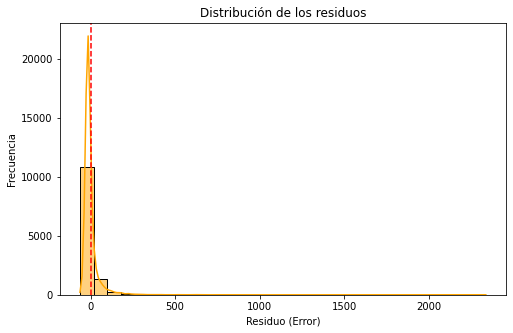

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sns.histplot(resultados_df["Residuo"], bins=30, kde=True, color='orange')
plt.title("Distribución de los residuos")
plt.xlabel("Residuo (Error)")
plt.ylabel("Frecuencia")
plt.axvline(0, color='red', linestyle='--')
plt.show()


       Valor Real   Estimado     Residuo
50815       -12.0   7.140302  -19.140302
60627         8.0  11.594721   -3.594721
59881         5.0   5.871659   -0.871659
55205       -19.0   5.494386  -24.494386
8909        143.0   8.400328  134.599672
27214       -14.0   0.480191  -14.480191
49803        11.0   8.587097    2.412903
16948       -37.0  -6.000475  -30.999525
60201        -2.0  10.340088  -12.340088
42123        -5.0   7.451089  -12.451089


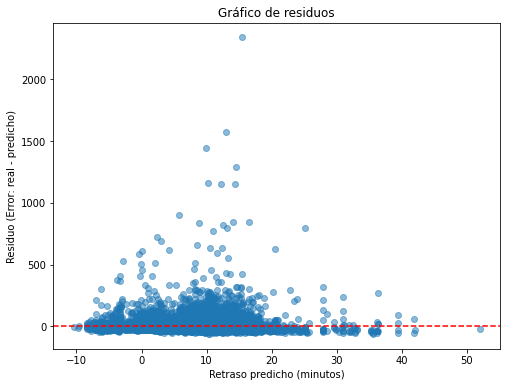

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegúrate que y_test y preds estén "alineados" y en formato compatible
y_test_series = y_test.squeeze()  # Si y_test es DataFrame, conviértelo a Serie

# Calcular residuos (error = real - predicho)
residuos = y_test_series - preds

# Crear DataFrame con valor real, estimado y residuo
resultados_df = pd.DataFrame({
    "Valor Real": y_test_series,
    "Estimado": preds,
    "Residuo": residuos
})

# Mostrar las primeras filas
print(resultados_df.head(10))

plt.figure(figsize=(8,6))
plt.scatter(resultados_df["Estimado"], resultados_df["Residuo"], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Retraso predicho (minutos)")
plt.ylabel("Residuo (Error: real - predicho)")
plt.title("Gráfico de residuos")
plt.show()


In [ ]:
X=flights_df[["op_carrier_airline_id","tail_num","origin_airport_id","dest_airport_id","distance","flights"]]
y=flights_df[["arr_delay"]]



Cargar modelo

In [ ]:
from catboost import CatBoostRegressor

# Crear instancia sin entrenar
modelo_cargado = CatBoostRegressor()

# Cargar los pesos
modelo_cargado.load_model("modelo_retrasos.cbm")
